# Data pipeline: Generating (shader, image) pairs

**Goal:** Create a high-quality dataset of (GLSL code, rendered image) pairs for VLM fine-tuning.

**Strategy:** Use headless EGL to render procedural shaders while stripping license headers and filtering for visual entropy.

In [5]:
# @title 1. Infrastructure and imports
import os
import sys
import subprocess
import math
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm

# 1. Mount Google Drive
from google.colab import drive, userdata
print("[SYSTEM] Mounting Google Drive...")
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Authenticate Hugging Face
from huggingface_hub import login
print("\n[AUTH] Authenticating Hugging Face...")
try:
    token = userdata.get('HF_TOKEN')
    login(token)
    print("   [OK] Authenticated via Token.")
except Exception:
    print("   [INFO] No Token found or Auth failed. Proceeding anonymously.")

# 3. Install System Dependencies (Headless EGL)
print("\n[SETUP] Installing Headless EGL Drivers...")
subprocess.run(["apt-get", "update"], check=True)
subprocess.run(["apt-get", "install", "-y", "python3-opengl", "libgl1-mesa-glx", "libegl1-mesa", "libgles2-mesa-dev", "xvfb"], check=True)
subprocess.run(["pip", "install", "moderngl", "pillow", "datasets", "tqdm"], check=True)

# 4. Import libraries that depend on the installs above
import moderngl
from datasets import load_dataset

[SYSTEM] Mounting Google Drive...

[AUTH] Authenticating Hugging Face...
   [OK] Authenticated via Token.

[SETUP] Installing Headless EGL Drivers...


In [6]:
# @title 2. Configuration
CONFIG = {
    # IO Paths
    "output_dir": "/content/drive/My Drive/projects/EarthShader/dataset",
    "dataset_id": "Vipitis/Shadereval-inputs",

    # Render Settings
    "resolution": (512, 512),
    "render_time": 1.0,

    # Filter Settings
    "min_entropy": 5.0,     # Filter out solid colors/black screens
    "max_samples": 1000,      # Adjust as needed.
}

# GLSL boilerplate
FRAGMENT_HEADER = """
#version 330
uniform vec2 iResolution;
uniform float iTime;
out vec4 fragColor;
"""

FRAGMENT_FOOTER = """
void main() {
    mainImage(fragColor, gl_FragCoord.xy);
}
"""

VERTEX_SHADER = """
#version 330
in vec2 in_vert;
void main() {
    gl_Position = vec4(in_vert, 0.0, 1.0);
}
"""

In [7]:
# @title 3. Engine logic (helpers)

def create_headless_context():
    """Creates a standalone ModernGL context supporting EGL or fallback."""
    try:
        return moderngl.create_context(standalone=True, backend='egl')
    except:
        return moderngl.create_context(standalone=True)

def calculate_visual_entropy(image):
    """Calculates Shannon entropy to detect empty/solid images."""
    histogram = image.histogram()
    histogram_length = sum(histogram)
    samples_probability = [float(h) / histogram_length for h in histogram]
    return -sum([p * math.log(p, 2) for p in samples_probability if p != 0])

def strip_shader_header(glsl_content):
    """
    Parses GLSL to remove license headers and comments.
    Returns the code starting from the first functional line.
    """
    lines = glsl_content.splitlines()
    start_index = 0
    in_multiline_comment = False

    for i, line in enumerate(lines):
        stripped = line.strip()

        # Skip empty lines and single-line comments
        if not stripped: continue
        if stripped.startswith('//'): continue

        # Handle block comments
        if '/*' in stripped:
            if '*/' in stripped:
                if not stripped.endswith('*/'):
                    start_index = i
                    break
                continue
            else:
                in_multiline_comment = True
                continue

        if in_multiline_comment:
            if '*/' in stripped:
                in_multiline_comment = False
            continue

        # Found real code
        start_index = i
        break

    return '\n'.join(lines[start_index:])

def render_shader(ctx, glsl_body, output_path):
    """Compiles and renders a shader to an image file. Returns True if successful."""
    full_source = f"{FRAGMENT_HEADER}\n{glsl_body}\n{FRAGMENT_FOOTER}"
    try:
        prog = ctx.program(vertex_shader=VERTEX_SHADER, fragment_shader=full_source)
        vertices = np.array([-1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0], dtype='f4')
        vbo = ctx.buffer(vertices)
        vao = ctx.vertex_array(prog, [(vbo, '2f', 'in_vert')])
        fbo = ctx.simple_framebuffer(CONFIG["resolution"])
        fbo.use()

        if 'iResolution' in prog: prog['iResolution'].value = CONFIG["resolution"]
        if 'iTime' in prog: prog['iTime'].value = CONFIG["render_time"]

        ctx.clear(0.0, 0.0, 0.0)
        vao.render(moderngl.TRIANGLE_STRIP)

        raw_data = fbo.read(components=3)
        img = Image.frombytes('RGB', fbo.size, raw_data)

        if calculate_visual_entropy(img) < CONFIG["min_entropy"]:
            return False

        img.save(output_path)
        fbo.release(); vao.release(); vbo.release(); prog.release()
        return True
    except Exception:
        return False

In [8]:
# @title 4. Pipeline execution

def run_pipeline():
    # Setup Directory
    if not os.path.exists(CONFIG["output_dir"]):
        os.makedirs(CONFIG["output_dir"], exist_ok=True)
        print(f"\n[INFO] Created Directory: {CONFIG['output_dir']}")
    else:
        print(f"\n[INFO] Found Directory: {CONFIG['output_dir']}")

    # Initialize source and context
    print(f"[INFO] Streaming Dataset: {CONFIG['dataset_id']}...")
    dataset = load_dataset(CONFIG["dataset_id"], split="test", streaming=True)

    ctx = create_headless_context()
    print("[INFO] Context Active. Starting ingestion...")

    valid_samples = 0
    pbar = tqdm(total=CONFIG["max_samples"], desc="Processing")

    for sample in dataset:
        if valid_samples >= CONFIG["max_samples"]:
            break

        # Extract and clean
        raw_code = sample.get('image_code', sample.get('image_coded', ''))
        if not raw_code: continue

        clean_code = strip_shader_header(raw_code)
        if not clean_code.strip(): continue

        # Paths
        img_path = os.path.join(CONFIG["output_dir"], f"shader_{valid_samples}.jpg")
        glsl_path = os.path.join(CONFIG["output_dir"], f"shader_{valid_samples}.glsl")

        # Render
        if render_shader(ctx, clean_code, img_path):
            with open(glsl_path, "w") as f:
                f.write(clean_code)

            valid_samples += 1
            pbar.update(1)

    print(f"\n[SUCCESS] Pipeline Complete. Saved {valid_samples} pairs.")

# Run
run_pipeline()


[INFO] Found Directory: /content/drive/My Drive/projects/EarthShader/dataset
[INFO] Streaming Dataset: Vipitis/Shadereval-inputs...
[INFO] Context Active. Starting ingestion...


Processing:  23%|██▎       | 231/1000 [01:33<05:12,  2.46it/s]


[SUCCESS] Pipeline Complete. Saved 231 pairs.


[INFO] Total Samples: 231
[INFO] Inspecting 3 random pairs...


/tmp/ipython-input-3505409768.py:65: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=3.0, w_pad=2.0)


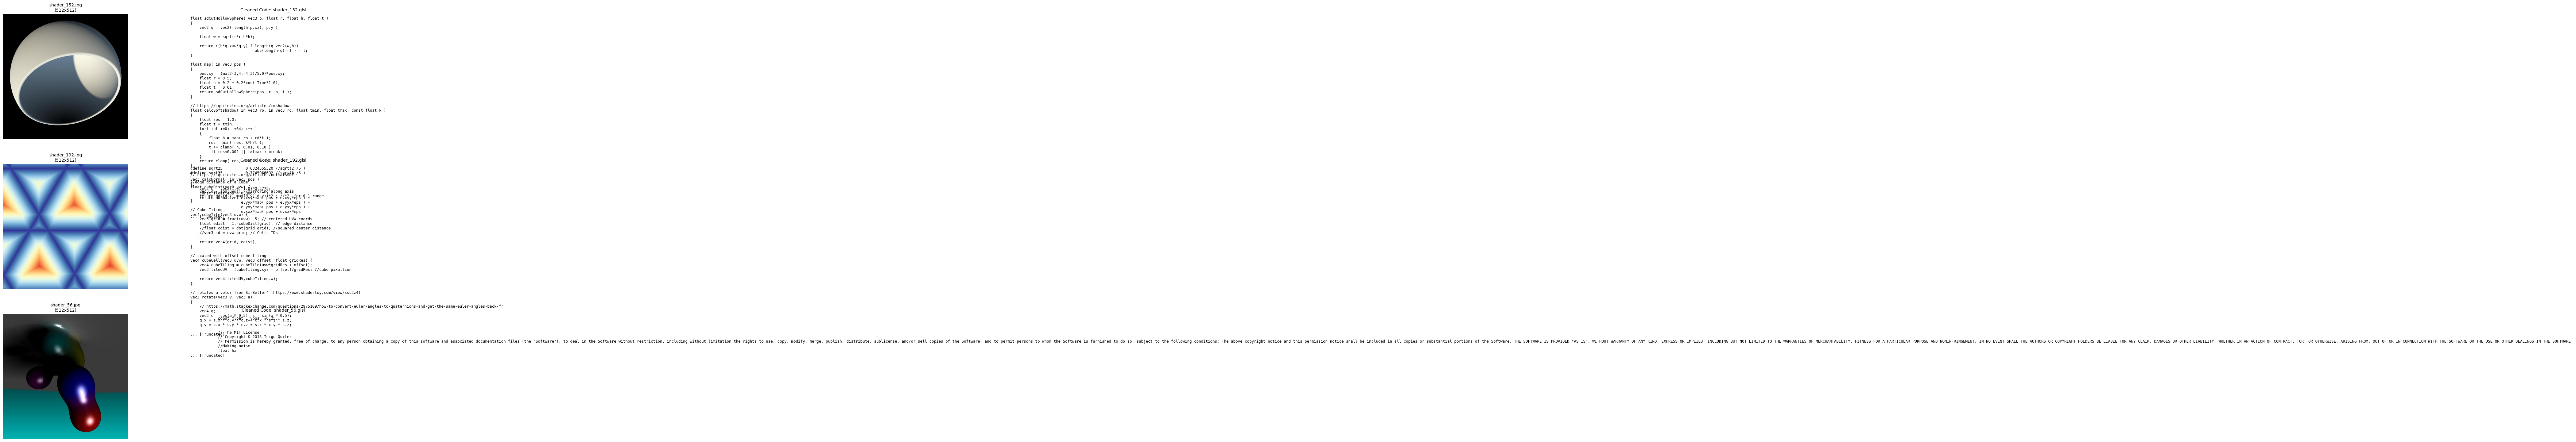

In [15]:
# @title 5. Verification (Unit Test)
import matplotlib.pyplot as plt
import random

def verify_data(num_samples=3):
    dataset_dir = CONFIG["output_dir"]

    if not os.path.exists(dataset_dir):
        print(f"[ERROR] Directory not found: {dataset_dir}")
        return

    files = sorted([f for f in os.listdir(dataset_dir) if f.endswith(".jpg")])
    if not files:
        print("[WARN] No images found.")
        return

    print(f"[INFO] Total Samples: {len(files)}")
    print(f"[INFO] Inspecting {num_samples} random pairs...")

    # Use subplots for precise layout control
    # Increased width (16) to give code more breathing room
    fig, axes = plt.subplots(num_samples, 2, figsize=(16, 6 * num_samples))

    # Handle edge case if num_samples=1 (axes is not a list of lists)
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        img_file = random.choice(files)
        base_name = img_file.replace(".jpg", "")
        code_file = base_name + ".glsl"

        ax_img = axes[i][0]
        ax_code = axes[i][1]

        try:
            # Load assets
            img = Image.open(os.path.join(dataset_dir, img_file))
            with open(os.path.join(dataset_dir, code_file), "r") as f:
                # FIX: Replace tabs with 4 spaces for clean display
                code = f.read().expandtabs(4)

            # Plot Left: Image
            ax_img.imshow(img)
            ax_img.axis("off")
            ax_img.set_title(f"{img_file}\n({img.size[0]}x{img.size[1]})", fontsize=10)

            # Plot Right: Code
            # transform=ax.transAxes guarantees text stays inside the box (0,1 = top-left)
            truncated_code = code[:1200] + ("\n... [Truncated]" if len(code) > 1200 else "")

            ax_code.text(0.02, 0.98, truncated_code,
                         transform=ax_code.transAxes,
                         fontsize=9,
                         family="monospace",
                         verticalalignment="top")

            ax_code.axis("off")
            ax_code.set_title(f"Cleaned Code: {code_file}", fontsize=10)

        except Exception as e:
            print(f"[ERROR] Reading {base_name}: {e}")

    # Add spacing between rows and columns
    plt.tight_layout(pad=3.0, w_pad=2.0)
    plt.show()

verify_data()